In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
from tqdm import tqdm
# import pickle

import hexbin_functions as hexfunc

/nethome/6525954/.conda/envs/nemo-ensemble/lib/python3.12/site-packages/h3/unstable/__init__.py:4: UserWarning: Modules under `h3.unstable` are experimental, and may change at any time.
  warnings.warn(


In [18]:
def entropy(Pdf):
    # Pdf = Pdf / np.nansum(Pdf)  # Normalize Pdf to sum to 1, ignoring NaNs
    # Replace zeros with a very small number to avoid log(0)
    Pdf_safe = np.where(Pdf > 0, Pdf, np.finfo(float).eps)
    return -np.nansum(Pdf_safe * np.log(Pdf_safe))

def information(Pdf):
    Pdf_safe = np.where(Pdf > 0, Pdf, np.finfo(float).eps)
    return - Pdf_safe * np.log2(Pdf_safe)

def Shannon_entropy(Pdf):
    # Pdf = Pdf / np.nansum(Pdf)  # Normalize Pdf to sum to 1, ignoring NaNs
    # Replace zeros with a very small number to avoid log(0)
    Pdf_safe = np.where(Pdf > 0, Pdf, np.finfo(float).eps)
    return -np.nansum(Pdf_safe * np.log2(Pdf_safe))

In [24]:
location = 'Cape_Hatteras'
member = 50
std = 0.01

file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_coarse/P_std{std*100:03.0f}_m{member:03d}.zarr"
P_m = xr.open_zarr(file_path)

In [25]:
hex_grid = hexfunc.int_to_hex(P_m.hexint.values)
hexbin_grid = hexfunc.hexGrid(hex_grid, h3_res=3)

In [26]:
P_m

<xarray.Dataset> Size: 208MB
Dimensions:      (delta_t: 4, time: 1400, hexint: 4644)
Coordinates:
  * delta_t      (delta_t) int64 32B 24 36 48 60
  * hexint       (hexint) int64 37kB 590889505955774463 ... 590726709515386879
  * time         (time) int64 11kB 0 1 2 3 4 5 ... 1394 1395 1396 1397 1398 1399
Data variables:
    entropy      (delta_t, time) float64 45kB dask.array<chunksize=(4, 1400), meta=np.ndarray>
    probability  (delta_t, hexint, time) float64 208MB dask.array<chunksize=(1, 581, 350), meta=np.ndarray>

In [27]:
# get dimensions
Members = [1, 2, 44, 46, 47, 48, 49, 50]
std_ranges = np.linspace(1, 20, 20)/100
delta_t_array = P_m.delta_t.values
time_array = P_m.time.values
bin_length = P_m.hexint.shape[0]

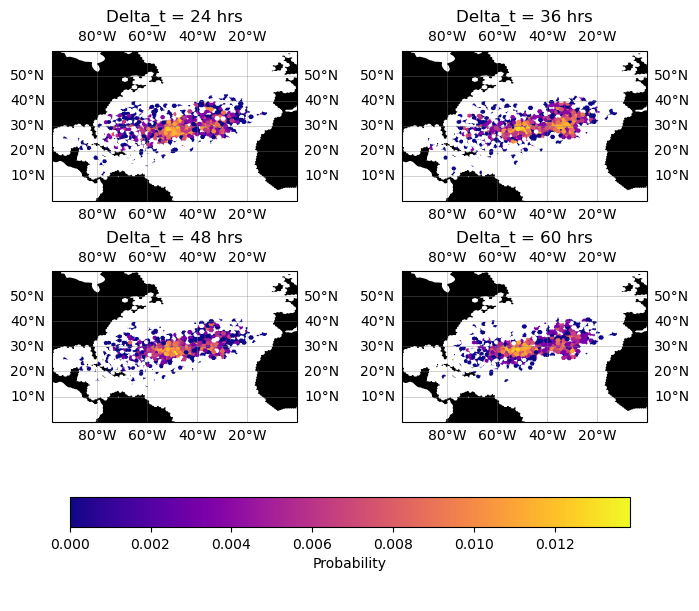

In [29]:
ncol = 2
nrow = 3
fig, axs = plt.subplots(ncols=ncol, nrows=nrow, figsize=(7, 6),
                       subplot_kw={'projection': cartopy.crs.PlateCarree()},
                       sharey=True, constrained_layout=True)

axs = axs.reshape(ncol*nrow)
t = 1200

for i, dt in enumerate(delta_t_array):
    
    axs[i].set_extent([-98, 0, 0, 60], crs=cartopy.crs.PlateCarree())
    axs[i].add_feature(cartopy.feature.LAND, zorder=0, color='black')
    
    axs[i].set_title(f'Delta_t = {dt} hrs')
    gl = axs[i].gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,
                         linewidth=0.5, color='gray', alpha=0.5)

    im = hexbin_grid.pcolorhex(P_m['probability'][i, :, t].values, ax=axs[i], cmap='plasma', draw_edges=False)



for i in range(ncol*nrow - nrow +1, ncol*nrow):
    axs[i].axis('off')
    
bar_ax = fig.add_axes([0.1, 0.13, 0.8, 0.05])
cbar = fig.colorbar(im, cax=bar_ax, orientation='horizontal', label='Probability')

In [11]:
P_m['entropy']

<xarray.DataArray 'entropy' (delta_t: 4, time: 1400)> Size: 45kB
dask.array<open_dataset-entropy, shape=(4, 1400), dtype=float64, chunksize=(4, 1400), chunktype=numpy.ndarray>
Coordinates:
  * delta_t  (delta_t) int64 32B 24 36 48 60
  * time     (time) int64 11kB 0 1 2 3 4 5 6 ... 1394 1395 1396 1397 1398 1399
Attributes:
    description:  Entropy values for each time step and observation time
    units:        nats

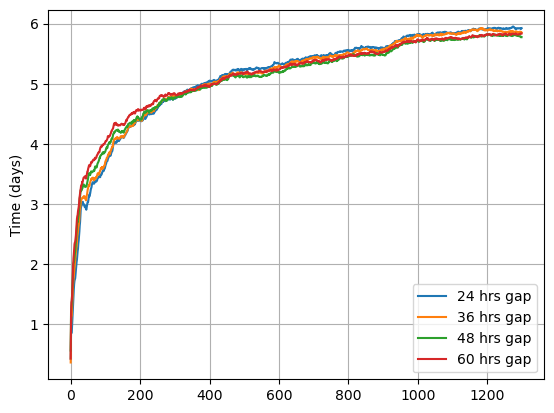

In [13]:
for i, dt in enumerate(delta_t_array):
    plt.plot(P_m['entropy'][i, :1300], label=f'{dt} hrs gap')
    
plt.legend()
plt.ylabel('Entropy (nats)')
plt.ylabel('Time (days)')
plt.grid()

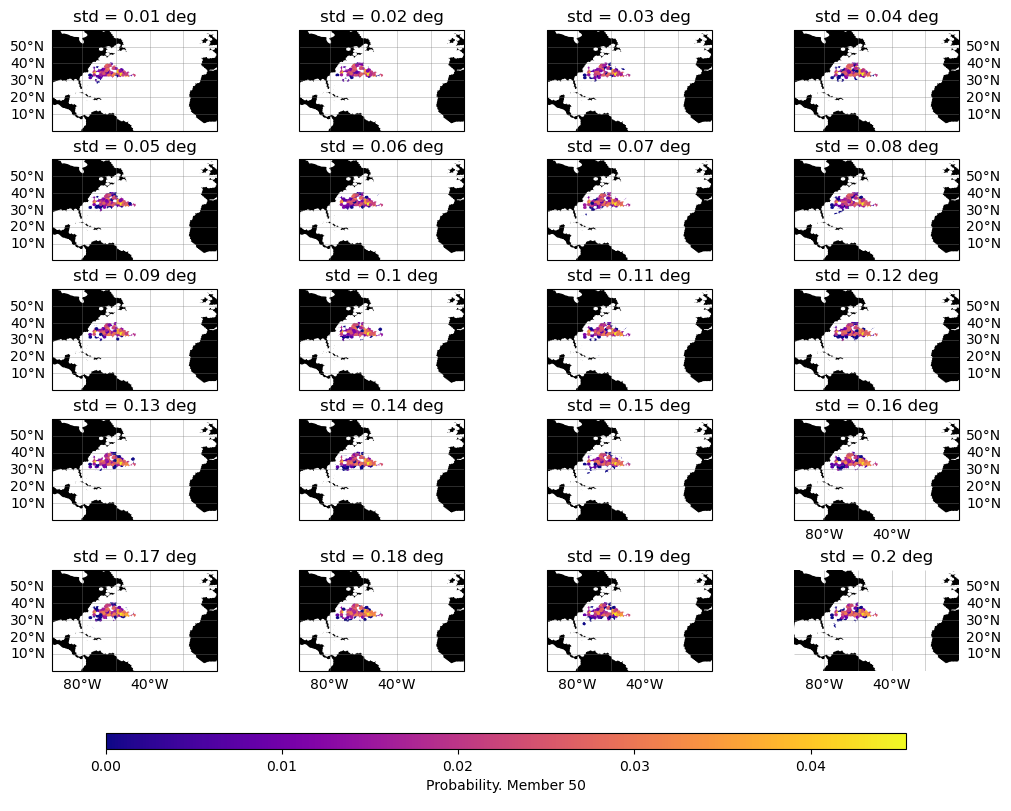

In [10]:
ncol = 4
nrow = 6
fig, axs = plt.subplots(ncols=ncol, nrows=nrow, figsize=(10, 8),
                       subplot_kw={'projection': cartopy.crs.PlateCarree()},
                       sharey=True, constrained_layout=True)

axs = axs.reshape(ncol*nrow)
t = 200

for i, std in enumerate(std_ranges):
    
    file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_coarse/P_std{std*100:03.0f}_m{member:03d}.zarr"
    P_m = xr.open_zarr(file_path)
    
    axs[i].set_extent([-98, 0, 0, 60], crs=cartopy.crs.PlateCarree())
    axs[i].add_feature(cartopy.feature.LAND, zorder=0, color='black')
    
    axs[i].set_title(f'std = {std} deg')
    gl = axs[i].gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,
                         linewidth=0.5, color='gray', alpha=0.5)

    im = hexbin_grid.pcolorhex(P_m['probability'][0, :, t].values, ax=axs[i], cmap='plasma', draw_edges=False)
    
    
    if i in [1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 15, 17, 18, 19]:
        gl.left_labels = False

    if i < 15:
        gl.bottom_labels = False

    gl.top_labels = False
    gl.right_labels = False

    if i in [3, 7, 11, 15, 19]:
        gl.right_labels = True

for i in range(ncol*nrow - nrow +1, ncol*nrow):
    axs[i].axis('off')

# ax[12].legend(handles=[h], loc='upper center', shadow=True)
bar_ax = fig.add_axes([0.1, 0.07, 0.8, 0.02])
cbar = fig.colorbar(im, cax=bar_ax, orientation='horizontal', label=f'Probability. Member {member}')

# plt.savefig(output_path + 'posterior.pdf', format='pdf')
# plt.savefig(output_path + 'posterior.jpg', format='jpg', dpi=300)

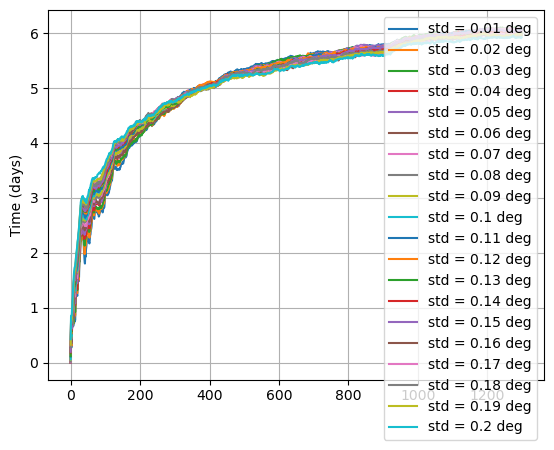

In [59]:
for i, std in enumerate(std_ranges):
    
    file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_coarse/P_std{std*100:03.0f}_m{member:03d}.zarr"
    P_m = xr.open_zarr(file_path)
    
    plt.plot(P_m['entropy'][0, :1300], label=f'std = {std} deg')
    
plt.legend()
plt.ylabel('Entropy (nats)')
plt.ylabel('Time (days)')
plt.grid()